In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm.auto import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
from aging.plotting import figure, save_factory, PlotConfig, format_plots, ONTOGENY_AGE_CMAP, add_identity, legend

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score

In [3]:
format_plots()
c = PlotConfig()

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cml=custom_cmap


# prepare colors for plot
colors = ['#dadaeb','#6a51a3']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
pl = sns.color_palette("dana", n_colors=42)

In [5]:
## update data
def filter_df(df):
    max=39
    thresh=8
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[data.index.get_level_values('age').isin(ages_greater)]

In [6]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [7]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid','mouse']).mean()
data = data.query('age<100')
data_all = data[sorted(data.columns)].copy()

In [8]:
df_indv=data_all.groupby(['mouse','age']).mean()

In [9]:
#days =df_indv['age'].to_numpy()
#df_indv['wks'] = np.floor(days/7).astype(int)
#df_indv['months'] = np.ceil(days/30).astype(int)
#df_indv.set_index(['wks','months'])

In [10]:
df=df_indv.copy().reset_index()

In [11]:
## decoder

In [12]:
# choose a model
clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 250)
#clf = LinearRegression()

# choose cross validation scheme
#cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
cv=5

#number of iterations for shuffle
it=10

In [13]:
xmale = pd.DataFrame()
a=0
n=16 # number of consecutive days for calculate over
age=[]
acc=[]
b=False
sh_acc=[]
sh_ages=[]
#while not b:
while True:
    # build the current age matrix
    for m,_df in enumerate(df.groupby('mouse')):
        xmale_temp = _df[1][a:a+n]
        xmale = pd.concat([xmale,xmale_temp])
    rep_counts = xmale.groupby('mouse')['age'].nunique()
    keep_mice = list(rep_counts[rep_counts >= n].index) # keep mice that have at least 5 sessions
    xmale = xmale[xmale['mouse'].isin(keep_mice)]
    if (xmale.empty) | (len(keep_mice)<2):
        break
    # run identity decoder for this matrix
    age.append(np.floor(np.mean(xmale['age'])).astype(int))
    ymale=xmale['mouse']
    x = xmale.drop(['mouse','age'], axis=1).to_numpy()
    x = np.log(x + 1e-6) # convert to linear ###uncomment when NOT using pcs!!!
    y_pred = cross_val_predict(clf, x, ymale, cv=cv)
    temp_acc=np.mean(np.mean(cross_val_score(clf, x, ymale, cv=cv)))
    acc.append(temp_acc)  
    
    #shuffle
    for i in tqdm(range(it)):
        ysh_temp=np.random.permutation(ymale)
        y_pred_temp = cross_val_score(clf, x, ysh_temp, cv=cv)
        sh_acc.append(np.mean(y_pred_temp))
        sh_ages.append(np.floor(np.mean(xmale['age'])).astype(int))

    # handle variables for the loop
    xmale = pd.DataFrame()
    #temp_acc=[]
    a=a+1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 56.59it/s]


In [14]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age

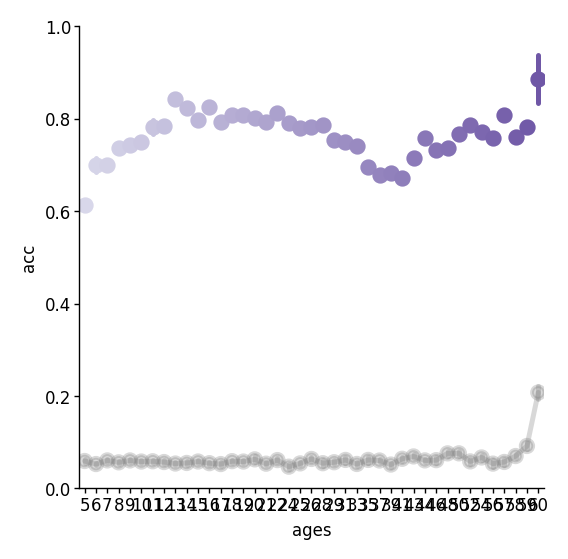

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))
#sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
#sns.pointplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
sns.pointplot(data=df_sh, x="ages", y="acc", ax=ax, color='grey',estimator='mean', errorbar='se',join=True)
plt.setp(ax.collections, alpha=.3) #for the markers
plt.setp(ax.lines, alpha=.3)       #for the lines
sns.pointplot(data=df, x="ages", y="acc",
              dodge=0, 
              join=True, 
              ax=ax, 
              scale=1,
              hue='ages',
              palette=pl,
              #edgecolor='gray',
              #linewidth=0.3
             )
plt.legend([],[], frameon=False)
#plt.xticks([])
ax.set_ylim([0,1])
sns.despine()
#ax.set_title('identity decoding in different ages bin=' + str(n))
fig.savefig(c.dana_save_path / "fig4"/ 'long_id_decoder_point_cv5.pdf')

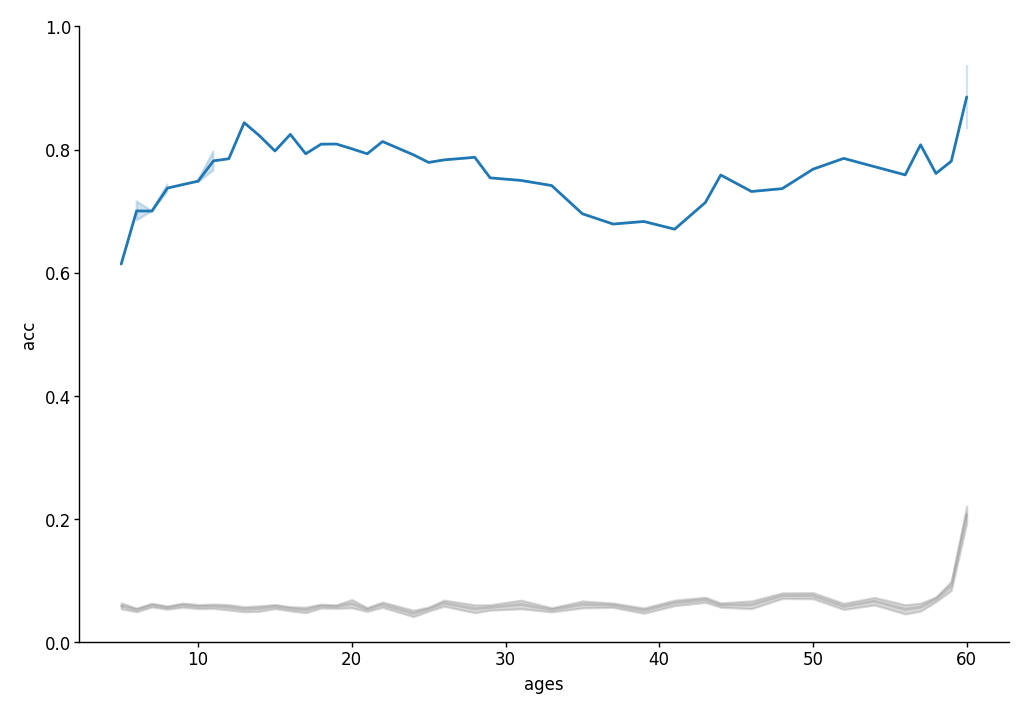

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
#sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
#sns.pointplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='grey',estimator='mean', errorbar='se')
plt.setp(ax.collections, alpha=.3) #for the markers
plt.setp(ax.lines, alpha=.3)       #for the lines
sns.lineplot(data=df, x="ages", y="acc",
              ax=ax, 
              #hue='ages',
              #palette=pl,
             estimator='mean', errorbar='se',
             )
plt.legend([],[], frameon=False)
#plt.xticks([])
ax.set_ylim([0,1])
sns.despine()
#ax.set_title('identity decoding in different ages bin=' + str(n))
fig.savefig(c.dana_save_path / "fig4"/ 'long_id_decoder_line.pdf')

In [17]:
# identity decoder from different datapoint to final datapoint

In [18]:
#create test data - average of the 5 final data point of each mouse
n2=4
xtest=pd.DataFrame()
df=df_indv.copy().reset_index()
for m,_df in enumerate(df.groupby('mouse')):
        xtest_temp = _df[1][-n2:]
        xtest = pd.concat([xtest,xtest_temp])

In [19]:
xtest = xtest.groupby('mouse').mean()
xt=xtest.drop(['age'], axis=1).to_numpy()
#xt=xtest.to_numpy()
xt = np.log(xt + 1e-6)
yt = xtest.index.get_level_values(0).to_numpy()

In [20]:
out = defaultdict(list)
xmale = pd.DataFrame()
out = defaultdict(list)
acc=[]
a=0
age=[]
acc=[]
b=False
sh_acc=[]
sh_ages=[]
#while not b:
while True:
    # build the current age matrix
    for m,_df in enumerate(df.groupby('mouse')):
        xmale_temp = _df[1][a:a+n]
        xmale = pd.concat([xmale,xmale_temp])
    rep_counts = xmale.groupby('mouse')['age'].nunique()
    keep_mice = list(rep_counts[rep_counts >= n].index) # keep mice that have at least 5 sessions
    xmale = xmale[xmale['mouse'].isin(keep_mice)]
    if (xmale.empty) | (len(keep_mice)<2):
        break
        
    # run identity decoder for this matrix
    age.append(np.floor(np.mean(xmale['age'])).astype(int))
    ymale=xmale['mouse']
    x = xmale.drop(['mouse','age'], axis=1).to_numpy()
    x = np.log(x + 1e-6) # convert to linear
    clf.fit(x, ymale)
    y_predict = clf.predict(xt)
    out['y_true'].append(yt)
    out['y_pred'].append(y_predict)
    out['acc'].append(accuracy_score(yt,y_predict))
    acc.append(accuracy_score(yt,y_predict))  

    #shuffle
    for i in tqdm(range(it)):
        ysh_temp=np.random.permutation(ymale)
        clf.fit(x, ysh_temp)
        shy_predict = clf.predict(xt)
        out['shy_pred'].append(shy_predict)
        out['sh_acc'].append(accuracy_score(yt,shy_predict))
        sh_acc.append(accuracy_score(yt,shy_predict))  
        sh_ages.append(np.floor(np.mean(xmale['age'])).astype(int))

    # handle variables for the loop
    xmale = pd.DataFrame()
    a=a+1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.89it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 156.45it/s]


In [21]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age

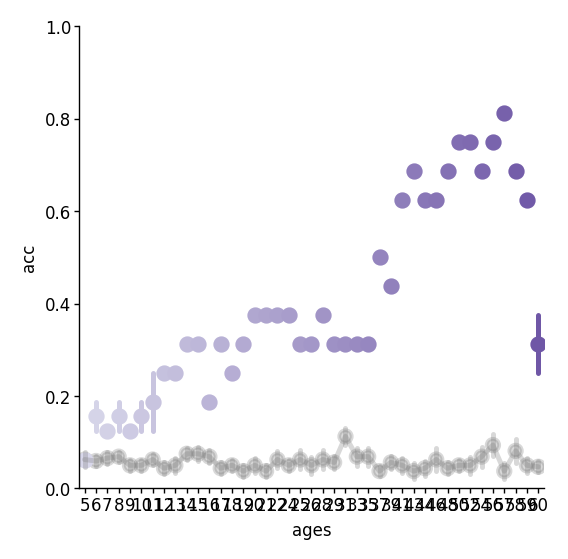

In [22]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.pointplot(data=df_sh, x="ages", y="acc", ax=ax, color='grey',estimator='mean', errorbar='se',join=True)
#sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='grey',estimator='mean', errorbar='se')
plt.setp(ax.collections, alpha=.3) #for the markers
plt.setp(ax.lines, alpha=.3)       #for the lines
#fig, ax = plt.subplots(figsize=(6, 6))
sns.pointplot(data=df, x="ages", y="acc",dodge=0, join=False, ax=ax, 
              #scale=1,
              hue='ages',
              palette=pl,
              #edgecolor='gray',
              #linewidth=0.3
             )
#sns.boxplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
#sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='blue',estimator='mean', errorbar='se')
plt.legend([],[], frameon=False)
#plt.xticks([])
ax.set_ylim([0,1])
sns.despine()
fig.savefig(c.dana_save_path / "fig4"/ 'long_id_decoder_end_point_cv5.pdf')